<a href="https://colab.research.google.com/github/BrenoMilagres/DataScienceProjetos_Python_R/blob/master/analise_risco_credito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de risco sobre prestação de crédito
#### Case para vaga analista de dados na MOVA - Breno Milagres
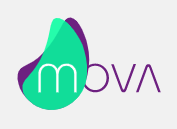
##### Dataset baixado no kaggle: https://www.kaggle.com/laotse/credit-risk-dataset



#### Dicionário de Variáveis
- **person_age**:	Idade do cliente
- **person_income**:	Rendimento anual
- **person_home_ownership**: Tipo de moradia
- **person_emp_length**:	Tempo de emprego (em anos)
- **loan_intent**: Finalidade do empréstimo
- **loan_grade**:	Grau de empréstimo
- **loan_amnt**:	Montante do empréstimo
- **loan_int_rate**:	Taxa de juros
- **loan_status**:	Status do empréstimo (0 = pago, 1 = não pago)
- **loan_percent_income**: quantos % o empréstimo corresponde da renda anual (empréstimo / Renda anual)
- **cb_person_default_on_file**:	Padrão histórico 
- **cb_preson_cred_hist_length**:	Há quanto tempo usa crédito 

#### Importando bibliotecas e Dataset 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import xgboost as xgb

In [2]:
#importando os dados para o google colab
from google.colab import files
uploaded = files.upload()

Saving credit_risk_dataset.csv to credit_risk_dataset.csv


In [2]:
df_cr = pd.read_csv('credit_risk_dataset.csv')
df_cr.tail()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26
32580,66,42000,RENT,2.0,MEDICAL,B,6475,9.99,0,0.15,N,30


#### Verificando se existem valores nulos

In [3]:
df_cr.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [4]:
#### Substituindo valores nulos pela média da coluna.
df_cr['person_emp_length'].fillna((df_cr['person_emp_length'].median()), inplace=True)
df_cr['loan_int_rate'].fillna((df_cr['loan_int_rate'].median()), inplace = True)
df_cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           32581 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               32581 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


#### Tratando variáveis categóricas com one hot enconding 

In [5]:
num_col = df_cr.select_dtypes(exclude = 'object')
char_col = df_cr.select_dtypes(include = 'object')
encoded_char_col = pd.get_dummies(char_col)
df_final = pd.concat([num_col, encoded_char_col], axis=1)
df_final.tail()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
32576,57,53000,1.0,5800,13.16,0,0.11,30,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
32577,54,120000,4.0,17625,7.49,0,0.15,19,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
32578,65,76000,3.0,35000,10.99,1,0.46,28,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
32579,56,150000,5.0,15000,11.48,0,0.10,26,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
32580,66,42000,2.0,6475,9.99,0,0.15,30,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


#### Análise explorátória

In [6]:
### Análise estatística
stats = ['person_age','person_income','person_emp_length','loan_amnt']
df_final[stats].describe()

,person_age,person_income,person_emp_length,loan_amnt
count,32581.000000,3.258100e+04,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.767994,9589.371106
std,6.348078,6.198312e+04,4.087372,6322.086646
min,20.000000,4.000000e+03,0.000000,500.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000
max,144.000000,6.000000e+06,123.000000,35000.000000


In [7]:
### Verificando quais labels são mais frequentes para variável loan_intent
df_cr['loan_intent'].value_counts()

EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: loan_intent, dtype: int64

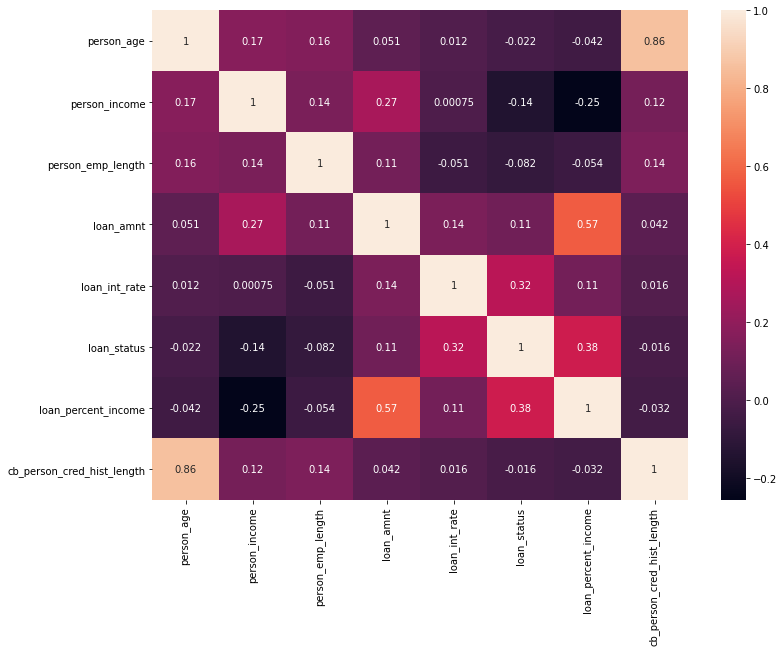

In [8]:
#matriz de correlação plotada
plt.figure(figsize=(12,9))
matriz_correlacao=df_cr.corr()
sns.heatmap(matriz_correlacao, annot=True)
plt.show()

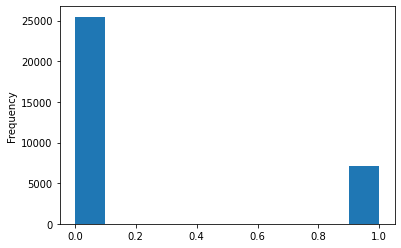

In [9]:
### Conferindo frequência das labels de saída
df_final.loan_status.plot(kind='hist')

gráfico configura um dataset desbalanceado, será necessário undersampling ou oversampling para treinar o modelo.

#### Dividindo entradas e saída.

In [33]:
X = df_final.drop(columns='loan_status')
y = df_final['loan_status']

### Tratando desbalanceamento 

In [34]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
np.bincount(y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


array([25473, 25473])

#### Normalizando Dados de entrada

In [35]:
from sklearn.preprocessing import scale
X_escaler = scale(X)

#### Dividindo dataset entre treino e teste

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_escaler, y, test_size=0.3, random_state=0)

#### Efetuando previsões 

#### Floresta Randômica

In [37]:

from sklearn.ensemble import RandomForestClassifier
#define a floresta randomica
clf_floresta = RandomForestClassifier(max_depth=9,n_estimators=100,min_samples_split=2,max_features='auto',oob_score=True,criterion='gini')
clf_floresta.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [38]:
y_pred_floresta = clf_floresta.predict(X_test)
print("Resultados para floresta randômica é:\n ",classification_report(y_test,y_pred_floresta))

O valor de f1-score para a floresta randômica é:
                precision    recall  f1-score   support

           0       0.91      0.98      0.94      7654
           1       0.97      0.90      0.94      7630

    accuracy                           0.94     15284
   macro avg       0.94      0.94      0.94     15284
weighted avg       0.94      0.94      0.94     15284



#### SVM

In [39]:
from sklearn.svm import SVC

clf_svm = SVC(kernel='rbf',gamma='auto',C=0.1)
clf_svm.fit(X_train,y_train)
y_pred_svm = clf_svm.predict(X_test)
print("Resultados para SVM:\n ",classification_report(y_test,y_pred_svm))

O valor de f1-score para Naive Bayes é:
                precision    recall  f1-score   support

           0       0.86      0.95      0.90      7654
           1       0.94      0.84      0.89      7630

    accuracy                           0.89     15284
   macro avg       0.90      0.89      0.89     15284
weighted avg       0.90      0.89      0.89     15284



#### gradient Boost



In [40]:
from sklearn.ensemble import GradientBoostingClassifier



clf_gradient = GradientBoostingClassifier(n_estimators=1000, learning_rate=1,max_depth=1 ,max_features='auto',subsample = 1, loss='exponential').fit(X_train, y_train)

y_pred_gradient = clf_gradient.predict(X_test)

print("REsultados para GradientBoos:\n ",classification_report(y_test,y_pred_gradient))
clf_gradient.score(X_test, y_test)
print(clf_gradient)

REsultados para GradientBoos:
                precision    recall  f1-score   support

           0       0.91      0.95      0.93      7654
           1       0.95      0.91      0.93      7630

    accuracy                           0.93     15284
   macro avg       0.93      0.93      0.93     15284
weighted avg       0.93      0.93      0.93     15284

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1, loss='exponential', max_depth=1,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1, tol=0.0001,
                           validation_fraction=0.1